2024-12-05 00:18:07,944 - INFO - Loading dataset...
2024-12-05 00:18:07,956 - INFO - Dataset loaded successfully.
2024-12-05 00:18:07,957 - INFO - Starting data preprocessing...
2024-12-05 00:18:07,958 - INFO - Starting data cleaning...
2024-12-05 00:18:07,990 - INFO - Data cleaning completed.
2024-12-05 00:18:07,992 - INFO - Starting feature engineering...
2024-12-05 00:18:08,022 - INFO - Feature engineering completed.
2024-12-05 00:18:08,026 - INFO - Splitting dataset into training and testing sets...
2024-12-05 00:18:08,036 - INFO - Training Random Forest model...
2024-12-05 00:18:09,106 - INFO - Evaluating model performance...
2024-12-05 00:18:09,189 - INFO - Model Performance - MAE: 32.7231980070341, RMSE: 41.546230468238655, R²: 0.9695042717481092
2024-12-05 00:18:09,190 - INFO - Final Model Evaluation:
2024-12-05 00:18:09,191 - INFO - MAE: 32.7231980070341
2024-12-05 00:18:09,193 - INFO - RMSE: 41.546230468238655
2024-12-05 00:18:09,194 - INFO - R²: 0.9695042717481092
2024-12-05

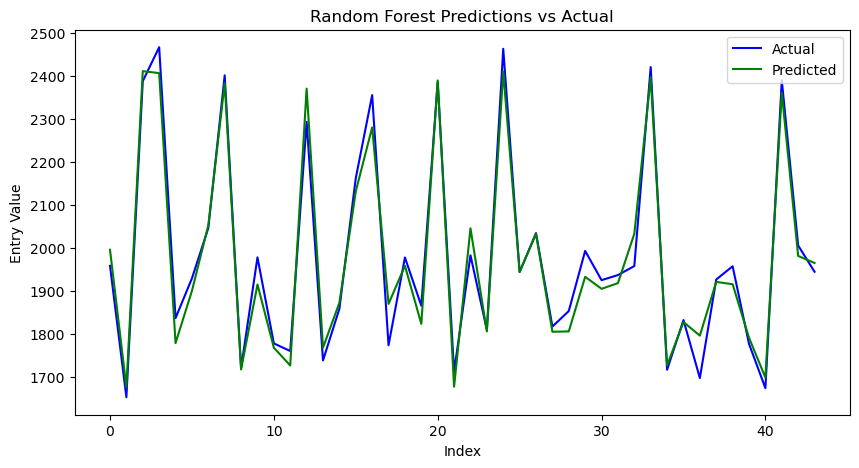

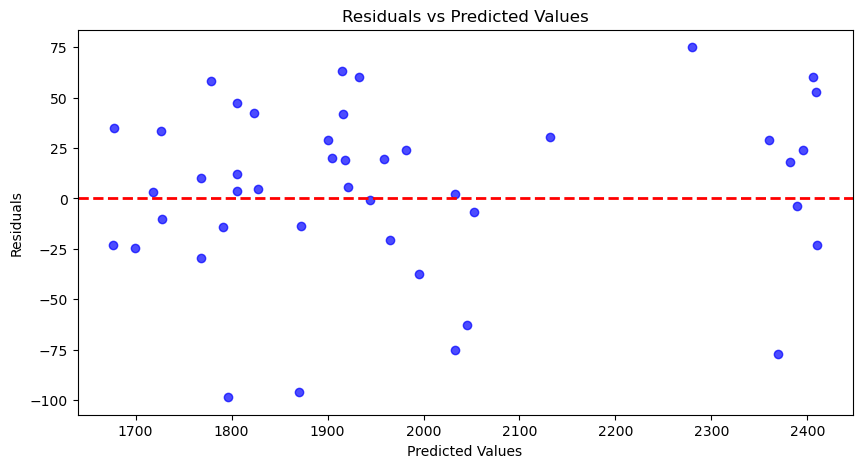

c:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


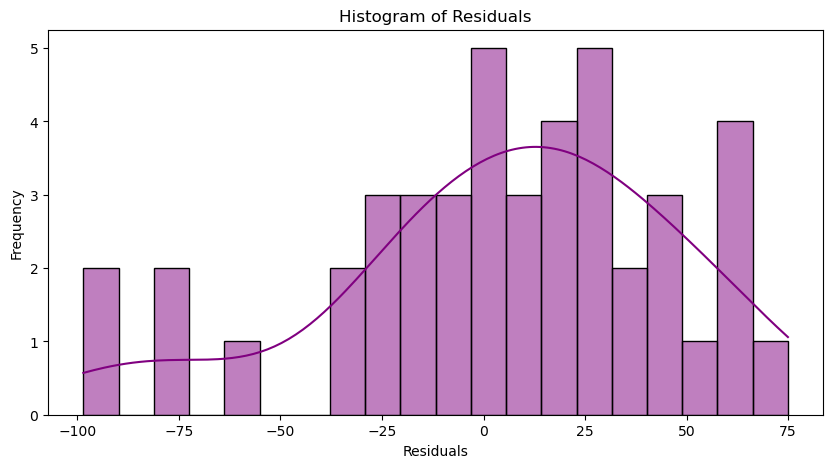

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Custom Transformer for Data Cleaning
class DataCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        logging.info("Starting data cleaning...")
        # Split columns
        data_split = X["Pair;Action;Tanggal Entry;Tanggal Exit;Entry;TP;SL;Keterangan"].str.split(";", expand=True)
        data_split.columns = ["Pair", "Action", "Tanggal Entry", "Tanggal Exit", "Entry", "TP", "SL", "Keterangan"]
        # Convert data types
        data_split['Entry'] = pd.to_numeric(data_split['Entry'], errors='coerce')
        data_split['TP'] = pd.to_numeric(data_split['TP'], errors='coerce')
        data_split['SL'] = pd.to_numeric(data_split['SL'], errors='coerce')
        data_split['Tanggal Entry'] = pd.to_datetime(data_split['Tanggal Entry'], errors='coerce')
        data_split['Tanggal Exit'] = pd.to_datetime(data_split['Tanggal Exit'], errors='coerce')
        # Drop NaN values
        cleaned_data = data_split.dropna()
        logging.info("Data cleaning completed.")
        return cleaned_data

# Custom Transformer for Feature Engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, max_lag=10):
        self.max_lag = max_lag
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        logging.info("Starting feature engineering...")
        for lag in range(1, self.max_lag + 1):
            X[f"Entry_lag_{lag}"] = X["Entry"].shift(lag)
        X["MA_3"] = X["Entry"].rolling(window=3).mean()
        X["MA_5"] = X["Entry"].rolling(window=5).mean()
        X["Volatility_3"] = X["Entry"].rolling(window=3).std()
        X["Volatility_5"] = X["Entry"].rolling(window=5).std()
        X["Return"] = X["Entry"].pct_change()
        X = X.dropna()
        logging.info("Feature engineering completed.")
        return X

# Pipeline definition
def create_pipeline(max_lag=10):
    pipeline = Pipeline([
        ('data_cleaning', DataCleaner()),
        ('feature_engineering', FeatureEngineer(max_lag=max_lag)),
    ])
    return pipeline

# Train and evaluate the model
def train_evaluate_model(X, y):
    logging.info("Splitting dataset into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logging.info("Training Random Forest model...")
    rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42)
    rf_model.fit(X_train, y_train)
    logging.info("Evaluating model performance...")
    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    logging.info(f"Model Performance - MAE: {mae}, RMSE: {rmse}, R²: {r2}")
    return mae, rmse, r2, y_test, y_pred

# Visualization function
def plot_results(y_test, y_pred):
    logging.info("Plotting results...")
    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label="Actual", color="blue")
    plt.plot(y_pred, label="Predicted", color="green")
    plt.title("Random Forest Predictions vs Actual")
    plt.xlabel("Index")
    plt.ylabel("Entry Value")
    plt.legend()
    plt.show()

    # Calculate residuals
    residuals = y_test - y_pred

    # Scatter plot of residuals vs predicted values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, alpha=0.7, color='blue')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.title("Residuals vs Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True, bins=20, color='purple')
    plt.title("Histogram of Residuals")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

# Main Execution
if __name__ == "__main__":
    logging.info("Loading dataset...")
    file_path = r"C:\Users\HP\Documents\data mining\backtest-template-v2 (9).csv"
    raw_data = pd.read_csv(file_path)
    logging.info("Dataset loaded successfully.")

    pipeline = create_pipeline(max_lag=10)
    logging.info("Starting data preprocessing...")
    preprocessed_data = pipeline.fit_transform(raw_data)

    # Define features and target
    y = preprocessed_data["Entry"]
    X = preprocessed_data[[f"Entry_lag_{lag}" for lag in range(1, 11)]]

    # Train and evaluate the model
    mae, rmse, r2, y_test, y_pred = train_evaluate_model(X, y)

    # Log final evaluation
    logging.info("Final Model Evaluation:")
    logging.info(f"MAE: {mae}")
    logging.info(f"RMSE: {rmse}")
    logging.info(f"R²: {r2}")

    # Plot results
    plot_results(y_test, y_pred)
